# Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

# Funções

In [2]:
# Ajuste da variável 'volume'
def convert_volume(volume):
    if isinstance(volume, str):  # Certifica que o volume é uma string
        if 'M' in volume:
            return float(volume.replace('M', '').replace(',', '.')) * 1e6
        elif 'K' in volume:
            return float(volume.replace('K', '').replace(',', '.')) * 1e3
        else:
            return float(volume.replace(',', '.'))
    else:
        return volume  # Retorna o valor original caso não seja string

# Preparação dos Dados

In [3]:
# Dados obtidos em: https://br.investing.com/indices/bovespa-historical-data

# Carga do CSV
data = pd.read_csv('dados/ibovespa-200407-202406.csv', dtype=str)

# Renomeando as variáveis
data.columns = ['date', 'closing', 'opening', 'max', 'min',
                'volume', 'variation']

# Date as date data type
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

# Limpeza dos caracteres para converter para float
for var in ['closing', 'opening', 'max', 'min', 'variation']:
    data[var] = data[var].str.replace('%', '')\
                         .str.replace('.', '')\
                         .str.replace(',', '.')\
                         .astype(float)

# Ajuste da variável 'volume'
data['volume'] = data['volume'].apply(convert_volume)

# Garantindo a ordenação
data = data.sort_values('date', ignore_index=True)

# Gravação do CSV com os dados tratados utilizado no modelo
data.to_csv('dados/dataset.csv', index=False)

# Descrição dos Dados

**Variáveis:**

|Variável|Descrição|
|-|-|
|date|Data do Pregão|
|closing|Valor no Fechamento|
|opening|Valor na Abertura|
|max|Valor Máximo|
|min|Valor Mínimo|
|volume|Volume Negociado|
|variation|Variação percentual com o fechamento do dia anterior|

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       4951 non-null   datetime64[ns]
 1   closing    4951 non-null   float64       
 2   opening    4951 non-null   float64       
 3   max        4951 non-null   float64       
 4   min        4951 non-null   float64       
 5   volume     4950 non-null   float64       
 6   variation  4951 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 270.9 KB


In [5]:
data.head()

,date,closing,opening,max,min,volume,variation
0,2004-07-01,21349.0,21152.0,21394.0,21094.0,336960000.0,0.95
1,2004-07-02,21568.0,21349.0,21747.0,21349.0,296500000.0,1.03
2,2004-07-05,21670.0,21565.0,21775.0,21429.0,122150000.0,0.47
3,2004-07-06,21188.0,21669.0,21669.0,21124.0,211350000.0,-2.22
4,2004-07-07,21171.0,21190.0,21364.0,21118.0,197800000.0,-0.08


In [6]:
data.describe(include=np.number)

,closing,opening,max,min,volume,variation
count,4951.000000,4951.000000,4951.000000,4951.000000,4.950000e+03,4951.000000
mean,69468.257322,69448.109069,70128.341345,68773.944860,2.648691e+07,0.049800
std,28556.985815,28554.637732,28731.113309,28376.914785,6.203949e+07,1.675283
min,20887.000000,20885.000000,21167.000000,20821.000000,1.121000e+05,-14.780000
25%,50443.000000,50431.500000,51086.000000,49905.000000,2.820000e+06,-0.820000
50%,61923.000000,61911.000000,62494.000000,61300.000000,4.425000e+06,0.070000
75%,95429.500000,95407.500000,96395.000000,94391.500000,1.146000e+07,0.960000
max,134194.000000,134194.000000,134392.000000,133832.000000,9.949600e+08,14.660000


In [7]:
print('Período: ', str(data['date'].min())[:10], 'à',
      str(data['date'].max())[:10])

Período:  2004-07-01 à 2024-06-28


# Prophet

In [8]:
# Dataset para o Prophet
prophet_df = data[['date', 'closing']]
prophet_df.columns = ['ds', 'y']

In [9]:
# Dados de teste e treino
prophet_train_size = int(len(prophet_df) * 0.75)
prophet_train_df = prophet_df[:prophet_train_size]
prophet_test_df = prophet_df[prophet_train_size:]

In [10]:
# Modelo
prophet_model = Prophet()
prophet_model.fit(prophet_train_df)

19:52:14 - cmdstanpy - INFO - Chain [1] start processing
19:52:15 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# Previsão
prophet_future = prophet_model\
                     .make_future_dataframe(periods=len(prophet_test_df))
prophet_forecast = prophet_model.predict(prophet_future)

In [12]:
# Extrai os resultados previstos
prophet_forecasted_values = prophet_forecast[['ds', 'yhat']]\
                                .tail(len(prophet_test_df))

In [13]:
# Combina os valores reais e previstos
prophet_results = prophet_test_df.merge(prophet_forecasted_values, on='ds')

In [14]:
# MAPE e WMAPE
prophet_mape = mean_absolute_percentage_error(prophet_results['y'],
                                              prophet_results['yhat'])
prophet_wmape = sum(abs(prophet_results['y'] - prophet_results['yhat']))\
                    / sum(prophet_results['y'])

print(f"Prophet MAPE: {prophet_mape}")
print(f"Prophet WMAPE: {prophet_wmape}")

Prophet MAPE: 0.16286013244420247
Prophet WMAPE: 0.15424768695032362


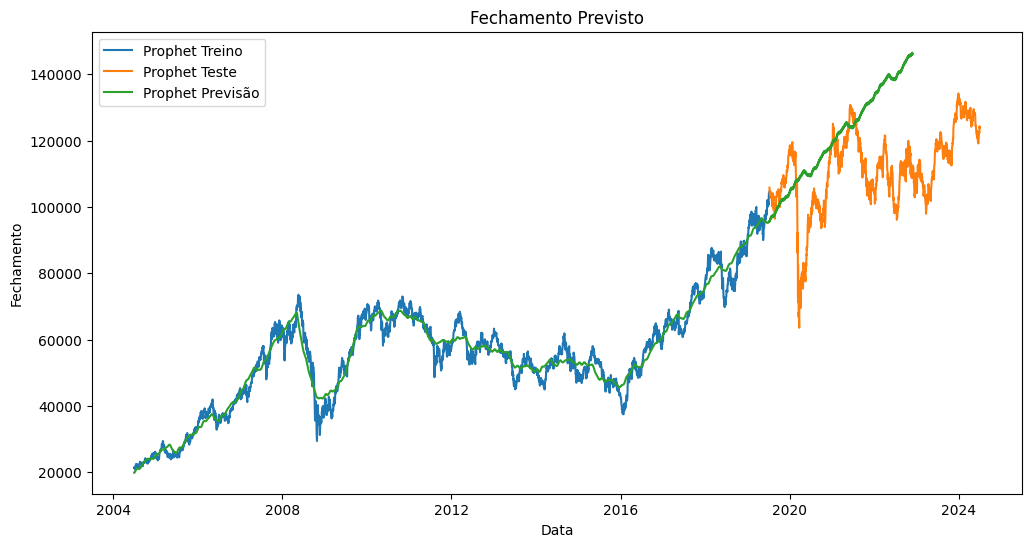

In [15]:
# Gráfico dos resultados
plt.figure(figsize=(12, 6))
plt.plot(prophet_train_df['ds'], prophet_train_df['y'],
         label='Prophet Treino')
plt.plot(prophet_test_df['ds'], prophet_test_df['y'],
         label='Prophet Teste')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'],
         label='Prophet Previsão')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.title('Fechamento Previsto')
plt.legend()
plt.show()